In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from defDef import *
import seaborn as sns
import scipy.stats as stats
from scipy.stats import linregress
import statsmodels.api as sm
import warnings

import tensorflow as tf
from tensorflow import keras as tf_keras

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# print 옵션
# pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.width', None)  # 열(칼럼) 생략없이
# pd.set_option('display.max_row', None)  # 행 생략없이
warnings.filterwarnings("ignore")


In [31]:
def preprocessing_net(df):
    # datetime을 제외한 모든 컬럼을 float으로 변경
    for col in df.columns:
        if col != 'datetime':
            try:
                df[col] = df[col].str.replace(',', '').astype(float)
            except:
                df[col] = df[col].astype(float)
    return df

def df_abs(df):
    # datetime을 제외한 모든 열에 절대값 적용
    for col in df.columns:
        if col != 'datetime':
            df[col] = df[col].abs()
    return df

In [32]:
# ----------------------------------------------------------------------------
# 데이터
# ----------------------------------------------------------------------------
ks = og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\kospi200\\일 ks200 90.01.13~24.01.19.csv'))

t_diff = 5

ks['t_change'] = (ks['c'].diff(t_diff) / ks['c'].shift(t_diff) * 100).abs()
ks['change'] = ((ks['c'] - ks['o']) / ks['o'] * 100).abs()
# ks['change'] = ((ks['c'] - ks['o']) / ks['o'] * 100)
# ks['change'] = np.log(ks['c']).diff()
ks['change_ma'] = ks['change'].rolling(63).mean()
ks['change_std'] = ks['change'].rolling(63).std()
ks['change_bbup'] = ks['change_ma'] + ks['change_std']
ks['change_bbdw'] = ks['change_ma'] - ks['change_std']

ks['range'] = (ks['h'] - ks['l']).abs()
ks['body'] = (ks['c'] - ks['o']).abs()

ks['body_up'] = 0
ks.loc[(ks['body'] > ks['body'].shift()), 'body_up'] = 1

ks['range_up'] = 0
ks.loc[(ks['range'] > ks['range'].shift()), 'body_up'] = 1

ks['change_up'] = 0
ks.loc[(ks['change'].abs() > ks['change'].abs().shift()), 'body_up'] = 1

ks['v_ma'] = ks['v'].rolling(252).mean()
ks['v_up'] = 0
ks.loc[ks['v'] > ks['v_ma'], 'v_up'] = 1
# ks['v_up'] = ks['v_up'].rolling(14).sum()

ks = og_Calculator.atr(ks, period=14)
ks = og_Calculator.atr_bands(ks, period=14, d=0.5)
# ks['atr_change'] = ((ks['atr'] - ks['atr'].shift(t_diff)) / ks['atr'].shift(t_diff) * 100).abs()

# y labeling
ks['y'] = 0

# og
# ks = og_Calculator.labeling(ks, case=0, v=None)
# ks['y'] = ks['y'].shift(-1)

ks.loc[(ks['range'].shift(-1) > ks['range']), 'y'] = 1

ks = ks[['datetime', 'change', 'range', 'body', 'y']]
ks

,datetime,change,range,body,y
0,1990-01-03,NaN,NaN,NaN,0
1,1990-01-04,NaN,NaN,NaN,0
2,1990-01-05,NaN,NaN,NaN,0
3,1990-01-08,NaN,NaN,NaN,0
4,1990-01-09,NaN,NaN,NaN,0
...,...,...,...,...,...
8378,2024-01-15,0.186055,2.88,0.63,1
8379,2024-01-16,0.897087,4.52,3.03,1
8380,2024-01-17,2.801705,10.00,9.40,0
8381,2024-01-18,0.076481,3.68,0.25,0


In [33]:
sentiment = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\created_csv\\sentiment.csv')
sentiment['datetime'] = pd.to_datetime(sentiment['datetime'])
sentiment = sentiment[['datetime', 'sentiment']]
sentiment

,datetime,sentiment
0,2007-05-08,0.158069
1,2007-05-09,0.130291
2,2007-05-10,0.380291
3,2007-05-11,0.378968
4,2007-05-14,0.337963
...,...,...
4101,2023-08-10,0.265212
4102,2023-08-11,0.142857
4103,2023-08-14,0.173942
4104,2023-08-15,0.127646


In [34]:
# options_o = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\spy_options_o.csv')
# options_h = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\spy_options_h.csv')
# options_l = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\spy_options_l.csv')
# options_c = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\spy_options_c.csv')
# options_v = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\spy_options_v.csv')

# options_o, options_h, options_l, options_c, options_v = DefColl.sync_dfs_lst([options_o, options_h, options_l, options_c, options_v])

# call_options = pd.DataFrame({
#     'datetime':options_o['datetime'],
#     'o':options_o['call'],
#     'h':options_h['call'],
#     'l':options_l['call'],
#     'c':options_c['call'],
#     'change':np.log(options_c['call']).diff(1),
#     'range':options_h['call'] - options_l['call'],
#     'body':(options_c['call'] - options_o['call']).abs()
# })
# put_options = pd.DataFrame({
#     'datetime':options_o['datetime'],
#     'o':options_o['put'],
#     'h':options_h['put'],
#     'l':options_l['put'],
#     'c':options_c['put'],
#     'change':np.log(options_c['put']).diff(1),
#     'range':options_h['put'] - options_l['put'],
#     'body':(options_c['put'] - options_o['put']).abs()
# })
# options = pd.DataFrame({
#     'datetime':call_options['datetime'],
#     'call_c':call_options['c'],
#     'put_c':put_options['c'],
#     'premium_sum':call_options['c'] + put_options['c'],
#     'premium_diff':call_options['c'] - put_options['c'],
#     'callput_ratio':options_v['call'] / options_v['put'],
#     'call_change':call_options['change'],
#     'call_range':call_options['range'],
#     'call_body':call_options['body'],
#     'put_change':put_options['change'],
#     'put_range':put_options['range'],
#     'put_body':put_options['body'],
# })

# # 이상치 제거
# options = options.dropna()[[col for col in options.columns if col not in ['callput_ratio', 'call_change', 'put_change']]]
# options

In [35]:
options_o = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\ks200_options_o_atm.csv')
options_h = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\ks200_options_h_atm.csv')
options_l = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\ks200_options_l_atm.csv')
options_c = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\ks200_options_c_atm.csv')
options_v = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\ks200_options_v.csv')

options_o, options_h, options_l, options_c, options_v = DefColl.sync_dfs_lst([options_o, options_h, options_l, options_c, options_v])

call_options = pd.DataFrame({
    'datetime':options_o['datetime'],
    'o':options_o['call'],
    'h':options_h['call'],
    'l':options_l['call'],
    'c':options_c['call'],
    'change':np.log(options_c['call']).diff(1),
    'range':options_h['call'] - options_l['call'],
    'body':(options_c['call'] - options_o['call']).abs()
})
put_options = pd.DataFrame({
    'datetime':options_o['datetime'],
    'o':options_o['put'],
    'h':options_h['put'],
    'l':options_l['put'],
    'c':options_c['put'],
    'change':np.log(options_c['put']).diff(1),
    'range':options_h['put'] - options_l['put'],
    'body':(options_c['put'] - options_o['put']).abs()
})
options = pd.DataFrame({
    'datetime':call_options['datetime'],
    'call_c':call_options['c'],
    'put_c':put_options['c'],
    'premium_sum':call_options['c'] + put_options['c'],
    'premium_diff':call_options['c'] - put_options['c'],
    'callput_ratio':options_v['call'] / options_v['put'],
    'call_change':call_options['change'],
    'call_range':call_options['range'],
    'call_body':call_options['body'],
    'put_change':put_options['change'],
    'put_range':put_options['range'],
    'put_body':put_options['body'],
})

# 이상치 제거
options = options[options['datetime'].dt.year >= 1999]
options

,datetime,call_c,put_c,premium_sum,premium_diff,callput_ratio,call_change,call_range,call_body,put_change,put_range,put_body
363,1999-01-04,5.50,1.11,6.61,4.39,0.401081,0.293761,1.85,0.75,-0.811931,1.31,1.09
364,1999-01-05,6.40,0.98,7.38,5.42,0.647816,0.151550,1.20,0.50,-0.124563,0.30,0.17
365,1999-01-06,6.95,0.55,7.50,6.40,0.414606,0.082444,0.75,0.55,-0.577634,0.56,0.35
366,1999-01-07,10.90,0.18,11.08,10.72,0.579686,0.450021,3.60,3.45,-1.116961,0.31,0.22
367,1999-01-08,9.30,0.19,9.49,9.11,0.636634,-0.158748,2.05,0.70,0.054067,0.32,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...
6538,2024-01-05,5.72,1.57,7.29,4.15,1.490398,-0.238411,1.80,0.97,0.019293,0.75,0.08
6539,2024-01-08,4.22,1.42,5.64,2.80,1.393188,-0.304134,3.46,2.91,-0.100419,0.94,0.42
6540,2024-01-09,2.89,1.24,4.13,1.65,1.445467,-0.378579,6.18,4.18,-0.135545,1.47,0.97
6541,2024-01-10,0.67,2.41,3.08,-1.74,1.145500,-1.461734,2.65,1.41,0.664515,2.17,0.96


In [36]:
es = og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\index\\일 S&P 500 79.12.26~.csv'))
es['change'] = (es['c'].diff() / es['c'].shift() * 100)
es['range'] = es['h'] - es['l']
es['body'] = (es['c'] - es['o']).abs()

es['ma1'] = es['c'].rolling(5).mean()
es['ma_up1'] = 0
es.loc[es['c'] > es['ma1'], 'ma_up1'] = 1

es['ma2'] = es['c'].rolling(21).mean()
es['ma_up2'] = 0
es.loc[es['c'] > es['ma2'], 'ma_up2'] = 1

es['ma3'] = es['c'].rolling(252).mean()
es['ma_up3'] = 0
es.loc[es['c'] > es['ma3'], 'ma_up3'] = 1

es['daily_var'] = (es['change']**2).rolling(5).sum()
es['weekly_var'] = es['change'].rolling(5).sum()**2
es['var_diff'] = es['daily_var'] - es['weekly_var']


es = es[['datetime', 'change', 'v']]
es

,datetime,change,v
0,1980-01-02,NaN,4.061000e+07
1,1980-01-03,-0.510591,5.048000e+07
2,1980-01-04,1.235503,3.913000e+07
3,1980-01-07,0.272250,4.450000e+07
4,1980-01-08,2.003557,5.339000e+07
...,...,...,...
11135,2024-03-04,-0.119326,2.818870e+09
11136,2024-03-05,-1.019310,2.704129e+09
11137,2024-03-06,0.514110,4.559050e+09
11138,2024-03-07,1.030413,2.359269e+09


In [37]:
ksvx = og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\volatility\\일 ksvx 03.01.02~24.01.19.csv'))
# ksvx = og_DefColl.day_to_weekmonth_without_keytype(ksvx, to='w')

ksvx['ma1'] = ksvx['c'].rolling(5).mean()
ksvx['ma_up1'] = 0
ksvx.loc[ksvx['c'] > ksvx['ma1'], 'ma_up1'] = 1

ksvx['ma2'] = ksvx['c'].rolling(21).mean()
ksvx['ma_up2'] = 0
ksvx.loc[ksvx['c'] > ksvx['ma2'], 'ma_up2'] = 1

ksvx['ma3'] = ksvx['c'].rolling(252).mean()
ksvx['ma_up3'] = 0
ksvx.loc[ksvx['c'] > ksvx['ma3'], 'ma_up3'] = 1

ksvx = ksvx[['datetime', 'c']]
ksvx

,datetime,c
0,2003-01-02,35.57
1,2003-01-03,34.50
2,2003-01-06,33.04
3,2003-01-07,33.98
4,2003-01-08,33.17
...,...,...
5201,2024-01-15,16.84
5202,2024-01-16,17.18
5203,2024-01-17,19.31
5204,2024-01-18,18.32


In [38]:
vx = og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\일 vx 90.01.03~.csv'))
# vx = og_DefColl.day_to_weekmonth_without_keytype(vx, to='w')

vx['ma1'] = vx['c'].rolling(5).mean()
vx['ma_up1'] = 0
vx.loc[vx['c'] > vx['ma1'], 'ma_up1'] = 1

vx['ma2'] = vx['c'].rolling(21).mean()
vx['ma_up2'] = 0
vx.loc[vx['c'] > vx['ma2'], 'ma_up2'] = 1

vx['ma3'] = vx['c'].rolling(252).mean()
vx['ma_up3'] = 0
vx.loc[vx['c'] > vx['ma3'], 'ma_up3'] = 1

vx = vx[['datetime', 'c']]
vx

,datetime,c
0,1990-01-02,17.240000
1,1990-01-03,18.190001
2,1990-01-04,19.219999
3,1990-01-05,20.110001
4,1990-01-08,20.260000
...,...,...
8607,2024-03-04,13.490000
8608,2024-03-05,14.460000
8609,2024-03-06,14.500000
8610,2024-03-07,14.440000


In [39]:
df = ks
df = pd.merge(df, es, how='inner', on='datetime')
df = pd.merge(df, vx, how='inner', on='datetime')
df = pd.merge(df, ksvx, how='inner', on='datetime')
df = pd.merge(df, sentiment, how='inner', on='datetime')
df = pd.merge(df, options, how='inner', on='datetime')

In [40]:
# D-1
# 모든 열을 한 번에 연결하여 새로운 DataFrame 생성
d1_df = pd.concat([df, df.shift(1).add_prefix('1d_')], axis=1)
# D-2
# 모든 열을 한 번에 연결하여 새로운 DataFrame 생성
d2_df = pd.concat([df, df.shift(2).add_prefix('2d_')], axis=1)
# D-3
# 모든 열을 한 번에 연결하여 새로운 DataFrame 생성
d3_df = pd.concat([df, df.shift(3).add_prefix('3d_')], axis=1)
# # D-4
# # 모든 열을 한 번에 연결하여 새로운 DataFrame 생성
d4_df = pd.concat([df, df.shift(4).add_prefix('4d_')], axis=1)
# # D-5
# # 모든 열을 한 번에 연결하여 새로운 DataFrame 생성
d5_df = pd.concat([df, df.shift(5).add_prefix('5d_')], axis=1)

df = pd.merge(df, d1_df, how='inner')
df = pd.merge(df, d2_df, how='inner')
df = pd.merge(df, d3_df, how='inner')
df = pd.merge(df, d4_df, how='inner')
df = pd.merge(df, d5_df, how='inner')

# drop
df.drop(columns=['1d_datetime'], inplace=True)
df.drop(columns=['2d_datetime'], inplace=True)
df.drop(columns=['3d_datetime'], inplace=True)
df.drop(columns=['4d_datetime'], inplace=True)
df.drop(columns=['5d_datetime'], inplace=True)

In [41]:
# y참조 제거
df = df[[col for col in df.columns if col[-3:] != 'd_y']]

# nan값 제거
# 무한대 값을 NaN으로 대체
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 포함하는 행 제거
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,datetime,change_x,range,body,y,change_y,v,c_x,c_y,sentiment,...,5d_put_c,5d_premium_sum,5d_premium_diff,5d_callput_ratio,5d_call_change,5d_call_range,5d_call_body,5d_put_change,5d_put_range,5d_put_body
0,2007-05-15,0.642211,3.01,1.32,0,-0.130398,3.071020e+09,14.010000,19.04,0.208333,...,0.10,5.95,5.75,0.811476,-0.058108,1.05,0.35,-0.530628,0.10,0.05
1,2007-05-16,0.587027,1.94,1.20,0,0.862654,2.915350e+09,13.500000,18.26,0.296958,...,0.02,7.92,7.88,0.912485,0.300421,2.25,2.05,-1.609438,0.08,0.06
2,2007-05-17,0.014470,1.01,0.03,1,-0.091802,2.868640e+09,13.510000,17.12,0.469577,...,0.01,10.01,9.99,1.159447,0.235722,2.25,1.55,-0.693147,0.00,0.00
3,2007-05-18,0.130460,2.41,0.27,1,0.661048,2.959050e+09,12.760000,17.12,0.410053,...,3.35,8.70,2.00,0.872633,-0.625489,1.60,0.75,5.814131,1.35,0.55
4,2007-05-21,1.606308,3.45,3.30,0,0.154324,3.465360e+09,13.300000,17.11,0.355159,...,3.50,8.65,1.65,0.771355,-0.038100,1.45,0.50,0.043803,1.28,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3854,2023-08-09,0.769912,3.93,2.61,0,-0.703873,3.803100e+09,15.960000,14.15,0.143519,...,1.63,7.23,3.97,0.815512,-0.732540,5.83,5.60,1.597243,1.49,1.16
3855,2023-08-10,0.226677,1.37,0.77,1,0.025071,4.504370e+09,15.850000,14.00,0.265212,...,2.26,6.25,1.73,1.080515,-0.338975,2.88,1.32,0.326785,1.67,0.59
3856,2023-08-11,0.848251,4.23,2.90,1,-0.106969,3.753290e+09,14.840000,13.44,0.142857,...,2.10,5.54,1.34,0.958591,-0.148320,1.44,1.05,-0.073427,1.01,0.24
3857,2023-08-14,0.664540,4.24,2.25,0,0.575048,3.896410e+09,14.820000,14.14,0.173942,...,2.25,4.48,-0.02,1.118360,-0.433470,2.16,0.45,0.068993,1.88,0.15


In [42]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# X, y
selected_col = [col for col in df.columns if col not in ['datetime', 'y']]
# selected_col = selected_col

df['datetime'] = pd.to_datetime(df['datetime'])

sampling_case = 0

random_state = 42
train_test_case = 1
if train_test_case == 1:  # train_test_split

    train_df = df[df['datetime'].dt.year < 2019]
    test_df = df[df['datetime'].dt.year >= 2019]

    if sampling_case == 1:
        # 클래스 분포 확인
        class_distribution = Counter(train_df['y'])
        # print("클래스 분포:", class_distribution)
        print("클래스 1 분포:", class_distribution[1] / (class_distribution[1] + class_distribution[0]), '%')
        print("클래스 0 분포:", class_distribution[0] / (class_distribution[1] + class_distribution[0]), '%')


        # 언더샘플링을 위한 목표 클래스 수 설정
        target_class_count = min(class_distribution.values())

        # RandomUnderSampler를 사용하여 언더샘플링 수행
        undersampler = RandomUnderSampler(sampling_strategy={key: target_class_count for key in class_distribution.keys()}, random_state=1)
        X_resampled, y_resampled = undersampler.fit_resample(train_df.drop(columns=['y']), train_df['y'])

        # 언더샘플링 후 클래스 분포 확인
        resampled_class_distribution = Counter(y_resampled)
        print("언더샘플링 후 클래스 분포:", resampled_class_distribution)

        # 언더샘플링된 데이터로 새로운 DataFrame 생성
        train_df = pd.DataFrame(X_resampled, columns=train_df.columns)
        train_df['y'] = y_resampled


    X = train_df[selected_col].values
    y = train_df['y'].values

    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=random_state)
    X_test, y_test = test_df[selected_col].values, test_df['y'].values

elif train_test_case == 2 : # 날짜
    # datetime 컬럼을 기준으로 train과 test 데이터프레임을 분리
    # train_df = pd.concat([df[(df['datetime'].dt.year != 2008) & (df['datetime'].dt.year != 2022)]])
    # test_df = pd.concat([df[(df['datetime'].dt.year == 2008) | (df['datetime'].dt.year == 2022)]])

    train_df = df[df['datetime'].dt.year < 2021]
    val_df = df[df['datetime'].dt.year == 2021]
    test_df = df[df['datetime'].dt.year > 2021]

    # train 데이터프레임 출력
    print("Train 데이터프레임:")
    print(train_df.head())

    # test 데이터프레임 출력
    print("\nTest 데이터프레임:")
    print(test_df.head())

    X_train, X_val, X_test, y_train, y_val, y_test = train_df[selected_col].values, val_df[selected_col].values, test_df[selected_col].values, train_df['y'].values, val_df['y'], test_df['y'].values

In [43]:
train_df[selected_col]

,change_x,range,body,change_y,v,c_x,c_y,sentiment,call_c,put_c,...,5d_put_c,5d_premium_sum,5d_premium_diff,5d_callput_ratio,5d_call_change,5d_call_range,5d_call_body,5d_put_change,5d_put_range,5d_put_body
0,0.642211,3.01,1.32,-0.130398,3.071020e+09,14.010000,19.04,0.208333,4.05,4.35,...,0.10,5.95,5.75,0.811476,-0.058108,1.05,0.35,-0.530628,0.10,0.05
1,0.587027,1.94,1.20,0.862654,2.915350e+09,13.500000,18.26,0.296958,4.95,3.35,...,0.02,7.92,7.88,0.912485,0.300421,2.25,2.05,-1.609438,0.08,0.06
2,0.014470,1.01,0.03,-0.091802,2.868640e+09,13.510000,17.12,0.469577,5.55,2.55,...,0.01,10.01,9.99,1.159447,0.235722,2.25,1.55,-0.693147,0.00,0.00
3,0.130460,2.41,0.27,0.661048,2.959050e+09,12.760000,17.12,0.410053,5.10,2.62,...,3.35,8.70,2.00,0.872633,-0.625489,1.60,0.75,5.814131,1.35,0.55
4,1.606308,3.45,3.30,0.154324,3.465360e+09,13.300000,17.11,0.355159,6.20,1.90,...,3.50,8.65,1.65,0.771355,-0.038100,1.45,0.50,0.043803,1.28,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777,0.530987,1.91,1.40,-2.058823,7.657890e+09,30.110001,18.67,0.832672,1.12,10.00,...,9.46,10.93,-7.99,1.025841,4.297285,1.30,1.03,1.330782,4.40,3.17
2778,0.356723,2.13,0.94,-2.711225,2.613670e+09,36.070000,19.49,0.779762,1.02,10.25,...,8.63,10.18,-7.08,1.025868,0.052993,0.28,0.00,-0.091828,1.21,0.38
2779,0.042131,3.14,0.11,4.959374,4.249740e+09,30.410000,21.74,0.733466,0.50,13.50,...,9.40,10.75,-8.05,0.877991,-0.138150,0.53,0.30,0.085465,1.80,0.60
2780,0.367071,1.98,0.96,0.856268,4.139010e+09,29.959999,19.26,0.750661,0.56,10.20,...,8.09,9.90,-6.28,1.138084,0.293222,0.51,0.35,-0.150081,1.34,0.71


In [44]:
# ----------------------------------------------------------------------------
# 클래스 분포 확인
# ----------------------------------------------------------------------------
# 'y' 값이 1 이상인 것과 이하인 것의 개수 계산
# y_values = train_df['y']
y_values = y_train

count_y_above_1 = np.sum(y_values >= 1)
count_y_below_1 = np.sum(y_values < 1)
total_count = len(y_values)

# 비율 계산
ratio_y_above_1 = count_y_above_1 / total_count
ratio_y_below_1 = count_y_below_1 / total_count

print("train y 값이 1 이상인 비율:", ratio_y_above_1, '% /', count_y_above_1, '개')
print("train y 값이 1 이하인 비율:", ratio_y_below_1, '% /', count_y_below_1, '개')

# 'y' 값이 1 이상인 것과 이하인 것의 개수 계산
y_values = test_df['y']
y_values = y_test

count_y_above_1 = np.sum(y_values >= 1)
count_y_below_1 = np.sum(y_values < 1)
total_count = len(y_values)

# 비율 계산
ratio_y_above_1 = count_y_above_1 / total_count
ratio_y_below_1 = count_y_below_1 / total_count

print("test y 값이 1 이상인 비율:", ratio_y_above_1, '% /', count_y_above_1, '개')
print("test y 값이 1 이하인 비율:", ratio_y_below_1, '% /', count_y_below_1, '개')

train y 값이 1 이상인 비율: 0.49520613614573344 % / 1033 개
train y 값이 1 이하인 비율: 0.5047938638542665 % / 1053 개
test y 값이 1 이상인 비율: 0.4744661095636026 % / 511 개
test y 값이 1 이하인 비율: 0.5255338904363974 % / 566 개


In [45]:
# ----------------------------------------------------------------------------
# 훈련 데이터에서 모델 하이퍼파라미터 튜닝 & 평가 
# ----------------------------------------------------------------------------
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, make_scorer, f1_score

def get_model():

    # default or 하이퍼파라미터 튜닝으로 선택된 최적 파라미터
    params = {
        'booster':'gbtree', 
        'objective':'binary:logistic',
        'learning_rate':0.1, 
        'max_depth':6,
        'gamma':0,
        'subsample':1,
        'colsample_bytree':1,
        'colsample_bylevel':1,
        'colsample_bynode':1,
        'lambda':1,
        'alpha':0,
        'num_boost_round':10,
        'min_child_weight':1
        }
    
    model = XGBClassifier(**params)
    return model

# 모델 평가
def get_score(model, X_train, y_train, X_val, y_val):

    # 모델 초기화
    model = get_model()

    # KFold 객체 생성
    kf = KFold(n_splits=5, shuffle=False)

    # 교차 검증 수행 (훈련 데이터셋으로)
    scoring = {'precision':make_scorer(precision_score, pos_label=1), 'recall':make_scorer(recall_score, pos_label=1)}
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring)

    # 교차 검증 결과 출력
    print('Train CV 모델 평가')
    print("평균 정밀도:", np.mean(cv_results['test_precision']))
    print("최고 정밀도:", np.max(cv_results['test_precision']))
    print("최저 정밀도:", np.min(cv_results['test_precision']))
    print()
    print("평균 재현율:", np.mean(cv_results['test_recall']))
    print("최고 재현율:", np.max(cv_results['test_recall']))
    print("최저 재현율:", np.min(cv_results['test_recall']))
    print()

    # 모델 초기화
    model = get_model()

    # 모델 훈련 (전체 훈련 데이터셋으로)
    model.fit(X_train, y_train)

    # 테스트 데이터셋으로 validation 평가
    y_pred = model.predict(X_val)

    # 평가 지표 계산
    precision = precision_score(y_val, y_pred, pos_label=1)
    recall = recall_score(y_val, y_pred, pos_label=1)
    f1 = f1_score(y_val, y_pred, pos_label=1)

    # 최종 평가 결과 출력
    print("Val 모델 평가:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

# case 선택
param_case = 2

if param_case == 1:  # 하이퍼파라미터 튜닝 안함
    model = get_model()
    get_score(model, X_train, y_train, X_val, y_val)

elif param_case == 2:  # 하이퍼파라미터 튜닝
    # parameter 들을 dictionary 형태로 설정
    params = {
        'booster':['gbtree'], 
        'objective':['binary:logistic'],
        'learning_rate':[0.1], 
        'max_depth':[3, 6 ,9],
        'gamma':[0],
        'subsample':[1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda':[1],
        'alpha':[0, 0.3, 0.6, 0.9],
        'num_boost_round':[10],
        'min_child_weight':[1]
        }

    # param_grid의 하이퍼 파라미터들을 train 테스트 수행 설정.  
    # refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재 학습 시킴.
    dtree = get_model()
    scoring = {'precision':make_scorer(precision_score, pos_label=1), 'recall':make_scorer(recall_score, pos_label=1), 'f1':make_scorer(f1_score, pos_label=1)}
    grid_dtree = GridSearchCV(estimator=dtree, param_grid=params, cv=3, scoring=scoring, refit=False)

    # # Train 데이터로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가 .
    grid_dtree.fit(X_train, y_train)

    # # GridSearchCV 결과 추출하여 DataFrame으로 변환
    train_scores_df = pd.DataFrame(grid_dtree.cv_results_)

    # 사용자 key 생성
    precision_scores_df = train_scores_df[[col for col in train_scores_df.columns if col.startswith('split') and col.endswith('precision')]]
    min_test_precision = precision_scores_df.min(axis=1)
    max_test_precision = precision_scores_df.max(axis=1)

    recall_scores_df = train_scores_df[[col for col in train_scores_df.columns if col.startswith('split') and col.endswith('recall')]]
    min_test_recall = recall_scores_df.min(axis=1)
    max_test_recall = recall_scores_df.max(axis=1)

    train_scores_df['min_test_precision'] = min_test_precision
    train_scores_df['max_test_precision'] = max_test_precision

    train_scores_df['min_test_recall'] = min_test_recall
    train_scores_df['max_test_recall'] = max_test_recall

    train_scores_df = train_scores_df[['params', 'rank_test_precision', 'mean_test_precision', 'min_test_precision', 'max_test_precision', 'rank_test_recall', 'mean_test_recall', 'min_test_recall', 'max_test_recall', 'rank_test_f1', 'mean_test_f1']]

    # param_grid의 하이퍼 파라미터들을 val 테스트 수행 설정.  
    # refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재 학습 시킴.
    dtree = get_model()
    scoring = {'precision':make_scorer(precision_score, pos_label=1), 'recall':make_scorer(recall_score, pos_label=1), 'f1':make_scorer(f1_score, pos_label=1)}
    grid_dtree = GridSearchCV(estimator=dtree, param_grid=params, cv=3, scoring=scoring, refit=False)

    # # Train 데이터로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가 .
    grid_dtree.fit(X_val, y_val)

    # # GridSearchCV 결과 추출하여 DataFrame으로 변환
    val_scores_df = pd.DataFrame(grid_dtree.cv_results_)

    # 사용자 key 생성
    precision_scores_df = val_scores_df[[col for col in val_scores_df.columns if col.startswith('split') and col.endswith('precision')]]
    min_test_precision = precision_scores_df.min(axis=1)
    max_test_precision = precision_scores_df.max(axis=1)

    recall_scores_df = val_scores_df[[col for col in val_scores_df.columns if col.startswith('split') and col.endswith('recall')]]
    min_test_recall = recall_scores_df.min(axis=1)
    max_test_recall = recall_scores_df.max(axis=1)

    val_scores_df['min_test_precision'] = min_test_precision
    val_scores_df['max_test_precision'] = max_test_precision

    val_scores_df['min_test_recall'] = min_test_recall
    val_scores_df['max_test_recall'] = max_test_recall

    val_scores_df = val_scores_df[['params', 'rank_test_precision', 'mean_test_precision', 'min_test_precision', 'max_test_precision', 'rank_test_recall', 'mean_test_recall', 'min_test_recall', 'max_test_recall', 'rank_test_f1', 'mean_test_f1']]

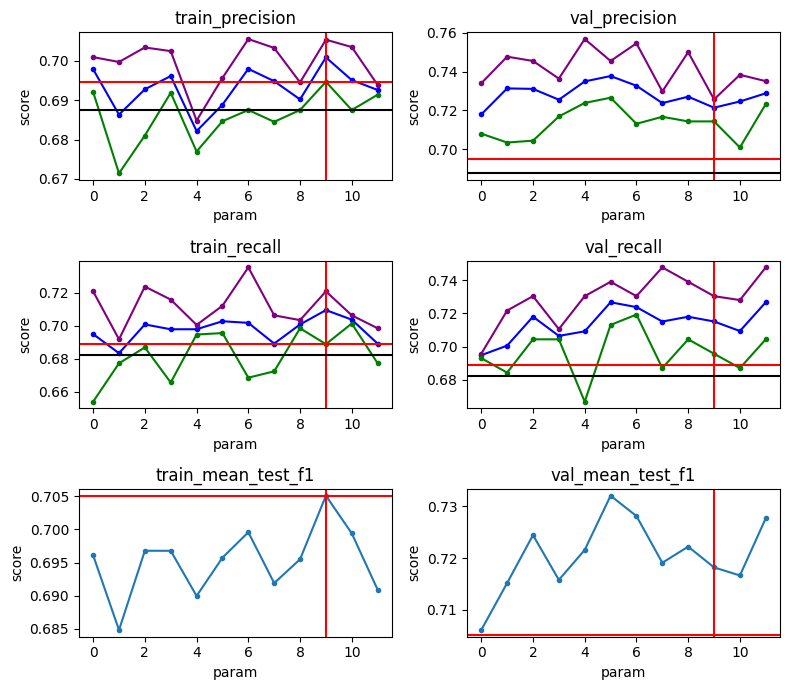

In [46]:
# 하이퍼파라미터 튜닝 시각화
if param_case == 2:

    # best parm case 1
    best_f1_idx = train_scores_df['rank_test_f1'].idxmin()
    # best parm case 2
    pre_stan, rec_stan = train_scores_df['min_test_precision'].median(), train_scores_df['min_test_recall'].median()
    # pre_stan, rec_stan = 0.4, 0.2
    best_idx_overmid = train_scores_df[(train_scores_df['min_test_precision'] > pre_stan) & (train_scores_df['min_test_recall'] > rec_stan)]['rank_test_f1'].idxmin()

    best_idx = best_idx_overmid

    best_idx_f1 = train_scores_df['mean_test_f1'][best_idx]
    best_idx_precision = train_scores_df['min_test_precision'][best_idx]
    best_idx_recall = train_scores_df['min_test_recall'][best_idx]

    plt.figure(figsize=(8, 7))

    # train
    plt.subplot(3, 2, 1)
    plt.title('train_precision')
    plt.plot(train_scores_df['mean_test_precision'], color='blue', marker='.')
    plt.plot(train_scores_df['max_test_precision'], color='purple', marker='.')
    plt.plot(train_scores_df['min_test_precision'], color='green', marker='.')
    plt.axvline(best_idx, color='red')  # best param
    plt.axhline(pre_stan, color='black')  # best score
    plt.axhline(best_idx_precision, color='red')  # 중위값
    plt.xlabel('param')
    plt.ylabel('score')

    plt.subplot(3, 2, 3)
    plt.title('train_recall')
    plt.plot(train_scores_df['mean_test_recall'], color='blue', marker='.')
    plt.plot(train_scores_df['max_test_recall'], color='purple', marker='.')
    plt.plot(train_scores_df['min_test_recall'], color='green', marker='.')
    plt.axvline(best_idx, color='red')
    plt.axhline(rec_stan, color='black')
    plt.axhline(best_idx_recall, color='red')
    plt.xlabel('param')
    plt.ylabel('score')

    plt.subplot(3, 2, 5)
    plt.title('train_mean_test_f1')
    plt.plot(train_scores_df['mean_test_f1'], marker='.')
    plt.axvline(best_idx, color='red')
    plt.axhline(best_idx_f1, color='red')
    plt.xlabel('param')
    plt.ylabel('score')

    # val
    plt.subplot(3, 2, 2)
    plt.title('val_precision')
    plt.plot(val_scores_df['mean_test_precision'], color='blue', marker='.')
    plt.plot(val_scores_df['max_test_precision'], color='purple', marker='.')
    plt.plot(val_scores_df['min_test_precision'], color='green', marker='.')
    plt.axvline(best_idx, color='red')  # best param
    plt.axhline(pre_stan, color='black')  # best score
    plt.axhline(best_idx_precision, color='red')  # 중위값
    plt.xlabel('param')
    plt.ylabel('score')

    plt.subplot(3, 2, 4)
    plt.title('val_recall')
    plt.plot(val_scores_df['mean_test_recall'], color='blue', marker='.')
    plt.plot(val_scores_df['max_test_recall'], color='purple', marker='.')
    plt.plot(val_scores_df['min_test_recall'], color='green', marker='.')
    plt.axvline(best_idx, color='red')
    plt.axhline(rec_stan, color='black')
    plt.axhline(best_idx_recall, color='red')
    plt.xlabel('param')
    plt.ylabel('score')

    plt.subplot(3, 2, 6)
    plt.title('val_mean_test_f1')
    plt.plot(val_scores_df['mean_test_f1'], marker='.')
    plt.axvline(best_idx, color='red')
    plt.axhline(best_idx_f1, color='red')
    plt.xlabel('param')
    plt.ylabel('score')

    plt.tight_layout()
    plt.show()

In [47]:
# 최적 하이퍼파라미터 확인
if param_case == 2:
    print('train best param:')
    print(train_scores_df.iloc[best_idx]['params'], best_idx)
    
    print('\ntrain_params:')
    for p in train_scores_df[:]['params'].tolist():
        print(p)

    # train_scores_df.sort_values(by='rank_test_f1', ascending=True)[:10]
    # train_scores_df

train best param:
{'alpha': 0.9, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'num_boost_round': 10, 'objective': 'binary:logistic', 'subsample': 1} 9

train_params:
{'alpha': 0, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'num_boost_round': 10, 'objective': 'binary:logistic', 'subsample': 1}
{'alpha': 0, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'num_boost_round': 10, 'objective': 'binary:logistic', 'subsample': 1}
{'alpha': 0, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_we

In [48]:
# 최적 하이퍼파라미터 선택 & 평가
if param_case == 2:
    # parameter 들을 dictionary 형태로 설정
    params = {
        'booster':'gbtree', 
        'objective':'binary:logistic',
        'learning_rate':0.1, 
        'max_depth':6,
        'gamma':0,
        'subsample':1,
        'colsample_bytree':1,
        'colsample_bylevel':1,
        'colsample_bynode':1,
        'lambda':1,
        'alpha':0,
        'num_boost_round':10,
        'min_child_weight':1
        }
    
    # 모델 초기화
    model = XGBClassifier(**params)

    # 평가
    get_score(model, X_train, y_train, X_val, y_val)

    # 모델 초기화
    model = XGBClassifier(**params)

Train CV 모델 평가
평균 정밀도: 0.6982316429059187
최고 정밀도: 0.7562189054726368
최저 정밀도: 0.6617647058823529

평균 재현율: 0.6987325448383994
최고 재현율: 0.7711442786069652
최저 재현율: 0.6696035242290749

Val 모델 평가:
Precision: 0.7082066869300911
Recall: 0.6773255813953488
F1 Score: 0.6924219910846954


In [49]:
# ----------------------------------------------------------------------------
# 테스트 데이터에서 모델 평가
# ----------------------------------------------------------------------------

# train val 결합
last_X_train = np.concatenate((X_train, X_val), axis=0)
last_y_train = np.concatenate((y_train, y_val), axis=0)

# 언더샘플링
if sampling_case == 1:
    # RandomUnderSampler 객체 생성
    undersampler = RandomUnderSampler(random_state=random_state)
    # 언더샘플링을 적용하여 데이터 분포 맞추기
    last_X_train, last_y_train = undersampler.fit_resample(last_X_train, last_y_train)
    # 언더샘플링 후의 클래스 분포 확인
    unique, counts = np.unique(y_resampled, return_counts=True)
    print(dict(zip(unique, counts)))

# 모델 초기화
if param_case == 1:
    model = get_model()
if param_case == 2:
    pass

# 모델 훈련
model.fit(last_X_train, last_y_train)

y_true = np.array(y_test)
y_pred = np.array(model.predict(X_test))

# 오차 행렬 생성
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

print("Confusion Matrix:")
print(cm)
print()

print('Test 모델 평가')
# 클래스 1에 대한 정밀도, 재현율, F1 점수 계산
precision_1 = precision_score(y_true, y_pred, pos_label=1)
recall_1 = recall_score(y_true, y_pred, pos_label=1)
f1_1 = f1_score(y_true, y_pred, pos_label=1)

print("Precision (정밀도) for class 1:", precision_1)
print("Recall (재현율) for class 1:", recall_1)
print("F1 Score for class 1:", f1_1)
print()

# 클래스 0에 대한 정밀도, 재현율, F1 점수 계산
precision_0 = precision_score(y_true, y_pred, pos_label=0)
recall_0 = recall_score(y_true, y_pred, pos_label=0)
f1_0 = f1_score(y_true, y_pred, pos_label=0)

print("Precision (정밀도) for class 0:", precision_0)
print("Recall (재현율) for class 0:", recall_0)
print("F1 Score for class 0:", f1_0)

Confusion Matrix:
[[290 221]
 [127 439]]

Test 모델 평가
Precision (정밀도) for class 1: 0.6954436450839329
Recall (재현율) for class 1: 0.5675146771037182
F1 Score for class 1: 0.625

Precision (정밀도) for class 0: 0.6651515151515152
Recall (재현율) for class 0: 0.7756183745583038
F1 Score for class 0: 0.7161500815660685


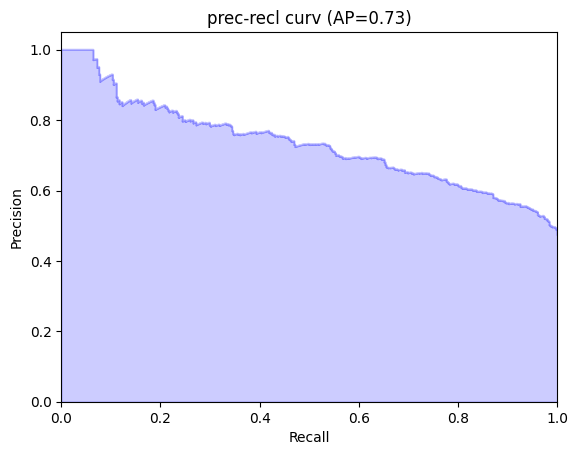

임계값: 0.006, 정밀도: 0.4745, 재현율: 1.0000
임계값: 0.007, 정밀도: 0.4749, 재현율: 1.0000
임계값: 0.008, 정밀도: 0.4753, 재현율: 1.0000
임계값: 0.008, 정밀도: 0.4758, 재현율: 1.0000
임계값: 0.009, 정밀도: 0.4762, 재현율: 1.0000
임계값: 0.009, 정밀도: 0.4767, 재현율: 1.0000
임계값: 0.011, 정밀도: 0.4771, 재현율: 1.0000
임계값: 0.013, 정밀도: 0.4776, 재현율: 1.0000
임계값: 0.013, 정밀도: 0.4780, 재현율: 1.0000
임계값: 0.013, 정밀도: 0.4785, 재현율: 1.0000
임계값: 0.014, 정밀도: 0.4789, 재현율: 1.0000
임계값: 0.014, 정밀도: 0.4794, 재현율: 1.0000
임계값: 0.014, 정밀도: 0.4798, 재현율: 1.0000
임계값: 0.015, 정밀도: 0.4803, 재현율: 1.0000
임계값: 0.017, 정밀도: 0.4807, 재현율: 1.0000
임계값: 0.017, 정밀도: 0.4812, 재현율: 1.0000
임계값: 0.018, 정밀도: 0.4816, 재현율: 1.0000
임계값: 0.019, 정밀도: 0.4821, 재현율: 1.0000
임계값: 0.021, 정밀도: 0.4825, 재현율: 1.0000
임계값: 0.021, 정밀도: 0.4830, 재현율: 1.0000
임계값: 0.021, 정밀도: 0.4834, 재현율: 1.0000
임계값: 0.022, 정밀도: 0.4839, 재현율: 1.0000
임계값: 0.022, 정밀도: 0.4844, 재현율: 1.0000
임계값: 0.022, 정밀도: 0.4848, 재현율: 1.0000
임계값: 0.023, 정밀도: 0.4853, 재현율: 1.0000
임계값: 0.023, 정밀도: 0.4857, 재현율: 1.0000
임계값: 0.024, 정밀도: 0.4862, 재현율: 1.0000
임

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 테스트 세트에 대한 예측을 수행합니다.
y_scores = model.predict_proba(X_test)[:, 1]

# 정밀도-재현율을 계산합니다.
precision, recall, _ = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# 정밀도-재현율 곡선을 그립니다.
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('prec-recl curv (AP={0:0.2f})'.format(average_precision))
plt.show()

from sklearn.metrics import precision_recall_curve

# 테스트 세트에 대한 예측 확률을 얻습니다.
y_scores = model.predict_proba(X_test)[:, 1]

# 정밀도-재현율 곡선을 그리기 위한 임계값 및 정밀도/재현율을 계산합니다.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# 임계값을 변경하여 정밀도와 재현율을 출력합니다.
for i, threshold in enumerate(thresholds):
    print("임계값: {:.3f}, 정밀도: {:.4f}, 재현율: {:.4f}".format(threshold, precision[i], recall[i]))

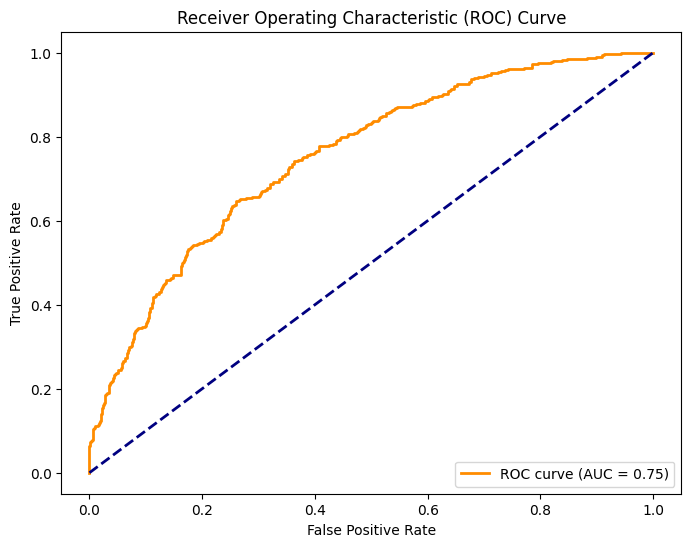

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 예측된 확률과 실제 레이블
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_true = np.array(y_test)

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [52]:
# ----------------------------------------------------------------------------
# 저장
# ----------------------------------------------------------------------------
# predict_df = pd.DataFrame()
# predict_df['datetime'] = test_df['datetime']
# predict_df['predict'] = model.predict(X_test)
# predict_df.to_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\created_csv\\predict_df.csv', index=False)
# predict_df